# Corona prepping using Finnish data EDA

## Main question: at this point we're interested in one single classification, i.e. __what predicts whether people do maskless contacts with non-householders__

[Research Document](https://docs.google.com/document/d/1iLciHcvVvf8QwFS7wiyNBevpD1B9yDRqMlM4_oCcVcA/edit?usp=sharing)

[Questions codebook](https://docs.google.com/document/d/1YZVCP1UNxnNLAK2kYDfA9Y98leTZYurZD-d8iByhdi0/edit?usp=sharing)

[Method of delivery](https://docs.google.com/document/d/1G1JT9JUJrTK3aaXXuRawYACJaGNxU7mcXL9i-d8eKXY/edit)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import session_info

from neuropy_frequentist_statistics import (normal_check, 
                                            analysis_independent_t_test,
                                            analysis_independent_mannwhitneyu_test,
                                            one_way_ANOVA,
                                            robust_rfecv
                                           )

from neuropy_correlation import correlation_analysis, plot_correlogram

from ml_class import (plot_cv_indices,
                      plot_decision_boundary,
                     plot_learning_curve,
                     multi_roc_auc_plot,
                     dict_of_models,
                     RFE_opt_rf,
                     make_confusion_matrix)

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, GroupKFold
# from sklearn.impute import IterativeImputer

/opt/miniconda3/envs/general/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE, RFECV

In [4]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier

In [5]:
from sklearn.model_selection import KFold

In [6]:
from sklearn import tree
import graphviz

In [7]:
import xgboost
import shap
shap.initjs()

In [8]:
_ = sns.set_style("whitegrid")

### Virtual Environments and Packages

In [9]:
session_info.show(req_file_name="corona_preppers-requirements.txt",
      write_req_file=False) #add write_req_file=True to function to get requirements.txt file of packages used

### Read in data, show info and data head

In [10]:
df = pd.read_csv("data/shield_gjames_21-06-10.csv").drop("id", axis=1)

In [11]:
df.head()

,demographic_gender,demographic_age,demographic_4_areas,demographic_8_areas,behaviour_indoors_nonhouseholders,behaviour_close_contact,behaviour_quarantined,behaviour_unmasked,mask_wearing_cloth_mask,mask_wearing_disposable_mask,...,sdt_motivation_introjected_3,attention_check,vaccination_status_intention_self,vaccination_status_closeones,covid_tested,had_covid,demographic_risk_group,needprotection_before_shots,needprotection_after_1_shot,needprotection_after_2_shots
0,1,50-59,1,2,5,4,2,5,0,1,...,2,2,1,1,1,1,2,1,2,3
1,2,30-39,2,6,5,4,2,5,1,1,...,7,1,2,2,3,2,2,1,2,5
2,1,18-29,1,2,3,2,2,2,0,1,...,3,1,3,1,2,5,2,1,1,7
3,1,60+,1,2,4,3,2,2,0,0,...,5,2,1,2,2,2,1,2,2,2
4,1,60+,2,7,5,4,2,4,0,1,...,6,1,1,4,3,1,2,1,1,3


In [12]:
sdt_columns = df.filter(regex="sdt").columns.tolist()

In [13]:
drop_sdt = False
if drop_sdt:
    df=df.drop(sdt_columns, axis=1)

In [14]:
df.shape

(2272, 92)

## Force all variables to categorical data

In [15]:
df = df.astype("category")

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2272 entries, 0 to 2271
Data columns (total 92 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   demographic_gender                 2272 non-null   category
 1   demographic_age                    2272 non-null   category
 2   demographic_4_areas                2272 non-null   category
 3   demographic_8_areas                2272 non-null   category
 4   behaviour_indoors_nonhouseholders  2272 non-null   category
 5   behaviour_close_contact            2272 non-null   category
 6   behaviour_quarantined              2272 non-null   category
 7   behaviour_unmasked                 2272 non-null   category
 8   mask_wearing_cloth_mask            2272 non-null   category
 9   mask_wearing_disposable_mask       2272 non-null   category
 10  mask_wearing_certified_mask        2272 non-null   category
 11  mask_wearing_ffp2                  2272 non

### Specify the feature list, grouping variable, and specify the grouping variable as a categorical variable

In [17]:
# Consider the interested group to analyze
grouping_var = "behaviour_unmasked"#"Q5" 

# Consider only numerical features
features_list = df.drop(grouping_var, axis=1).columns.tolist()
# features_list = code_df.loc[code_df["Of primary interest as a predictor (i.e. feature)?"]!="no", "Variable name"].values.tolist()
# make sure the target is not included in the features_list
try:
    _ = features_list.remove(grouping_var)
except:
    print(f"The grouping variable {grouping_var} was not present in the feature list to remove.")

# df[grouping_var] = df[grouping_var].astype("category")

The grouping variable behaviour_unmasked was not present in the feature list to remove.


### Creating a boolean version of the grouping variable

In [18]:
if grouping_var == "behaviour_unmasked":
    df[f"{grouping_var}_bool"] = (df[grouping_var] != 5).astype(int) #all the answers other than 5 are considered a 1 in the boolean
elif grouping_var == "demographic_age":
    df = (df
          .assign(PT_AGE_bool=lambda x: x["demographic_age"]
                  .isin(["40-49", "50-59"]) #ages 40 - 59 are considere 1 in the boolean
                  .astype(int))
         .loc[df["PT_AGE"] != "60+", :])
# elif grouping_var == "Q8_3":
#     df = df.assign(Q8_3_bool=lambda x: x["Q8_3"]
#                   .isin([1, 4]) #answers 1 and 4 are considered 1 in the boolean
#                   .astype(int))
else:
    raise ValueError(f"The grouping variable {grouping_var} is not currently supported, please choose from Q5, Q8_3 or PT_AGE.")

## EDA on the target
Check the amount of samples in the target

In [19]:
print(df[grouping_var].value_counts())
print(df[f"{grouping_var}_bool"].value_counts())

5    881
4    823
3    277
1    165
2    126
Name: behaviour_unmasked, dtype: int64
1    1391
0     881
Name: behaviour_unmasked_bool, dtype: int64


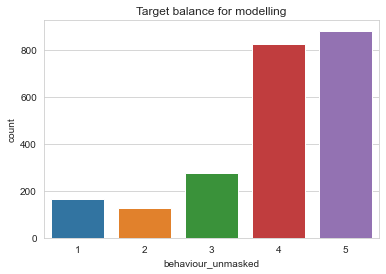

In [20]:
_ = sns.countplot(x=df[grouping_var])
_ = plt.title("Target balance for modelling")
_ = plt.show()

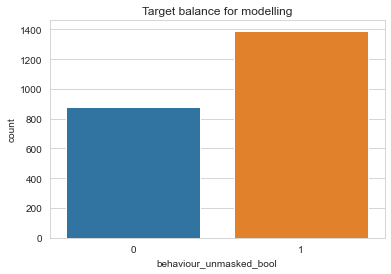

In [21]:
_ = sns.countplot(x=df[f"{grouping_var}_bool"])
_ = plt.title("Target balance for modelling")
_ = plt.show()

In [22]:
grouping_var = f"{grouping_var}_bool" #"Q5_bool"
# grouping_var = "PT_AGE_bool" #"Q5_bool"
# grouping_var = "Q5_bool"

In [23]:
y = df[grouping_var]
X = df[features_list[2:]]

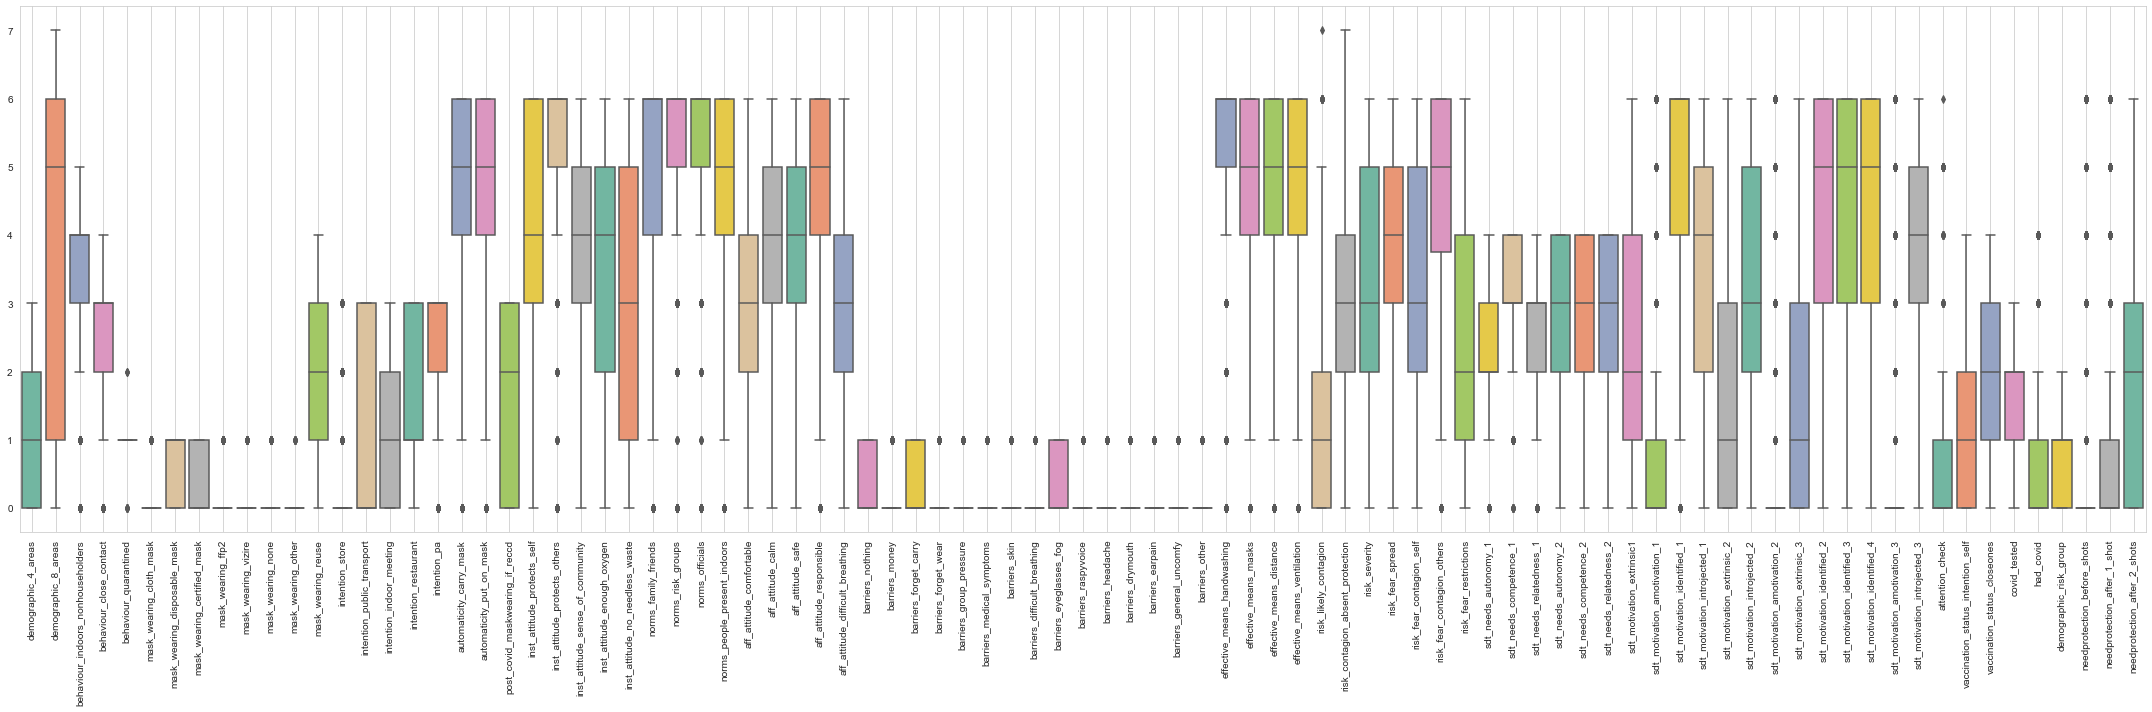

In [24]:
boxplot, ax = plt.subplots(figsize=(30,10))
_ = sns.boxplot(ax=ax, data=X.apply(lambda x: x.cat.codes), orient="v", palette="Set2")
_ = plt.setp(ax.get_xticklabels(), rotation=90)
_ = plt.grid()
_ = plt.tight_layout()
_ = plt.show()

In [25]:
# _ = plot_correlogram(data=X.apply(lambda x: x.cat.codes),
#                     check_norm=False,
#                     method='spearman',
#                     dropna='pairwise',
#                     margins=None,
#                     font_scale=0.6,
#                     show_p=True,
#                     figsize=(30, 30))

In [26]:
# Model pipeline (preprocessing, feature selection, regression)
# pipe = Pipeline([
#     ('imputer', IterativeImputer()),
# #     ('scaler', StandardScaler()),
# ])

clf = [AdaBoostClassifier(), 
       RandomForestClassifier(), 
       LinearDiscriminantAnalysis(), 
#        HistGradientBoostingClassifier(categorical_features=list(range(X.shape[1])))
#        LogisticRegression(), 
       SVC(kernel='linear', C=10)
      ]

rfecv for classification problem with 4 ML models with accuracy score


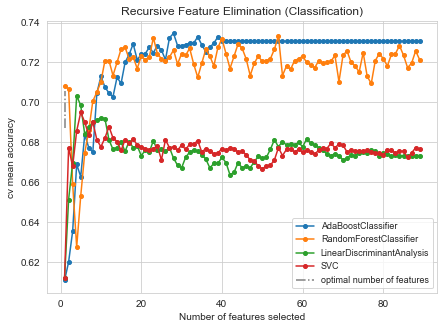

In [27]:
df_summary, df_feature, fig = robust_rfecv(
    X=X, 
    y=y, 
    model_list=clf, 
    preprocessing_pipe=None, 
    scoring='accuracy', 
    cv=KFold(5), 
#     groups=groups
)

In [28]:
df_summary

,optimal_n_features,highest_performance,score
AdaBoostClassifier,28,0.72,accuracy
RandomForestClassifier,54,0.72,accuracy
LinearDiscriminantAnalysis,4,0.68,accuracy
SVC,5,0.68,accuracy


In [29]:
df_feature.head(7)

,AdaBoostClassifier,RandomForestClassifier,LinearDiscriminantAnalysis,SVC,intersection
0,aff_attitude_comfortable,aff_attitude_calm,barriers_forget_carry,barriers_forget_carry,behaviour_indoors_nonhouseholders
1,aff_attitude_responsible,aff_attitude_comfortable,barriers_group_pressure,barriers_group_pressure,NaN
2,aff_attitude_safe,aff_attitude_difficult_breathing,behaviour_indoors_nonhouseholders,barriers_money,NaN
3,automaticity_put_on_mask,aff_attitude_safe,behaviour_quarantined,behaviour_indoors_nonhouseholders,NaN
4,barriers_money,attention_check,NaN,norms_people_present_indoors,NaN
5,behaviour_close_contact,automaticity_carry_mask,NaN,NaN,NaN
6,behaviour_indoors_nonhouseholders,automaticity_put_on_mask,NaN,NaN,NaN


In [30]:
X = df.loc[:, df_feature["intersection"].dropna().values.tolist()]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
clf1 = AdaBoostClassifier()
clf2 = RandomForestClassifier()
# clf3 = LinearDiscriminantAnalysis()
clf3 = HistGradientBoostingClassifier(categorical_features=list(range(X.shape[1])))

eclf1 = VotingClassifier(estimators=[
         ('ad', clf1), ('rf', clf2), ('lda', clf3)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)

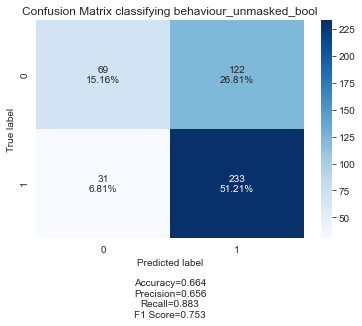

In [33]:
pred_y = eclf1.predict(X_test)
cf_matrix = confusion_matrix(y_test, pred_y)

_ = make_confusion_matrix(cf=cf_matrix, 
                  title=f"Confusion Matrix classifying {grouping_var}",
                 sum_stats=True)

AdaBoostClassifier()


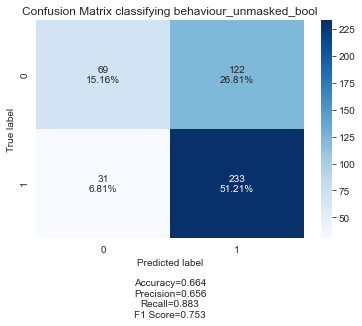

RandomForestClassifier()


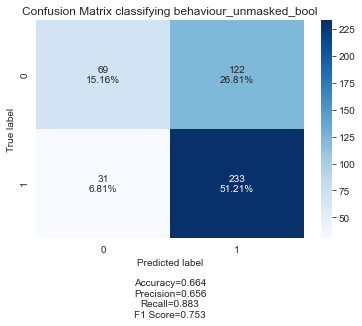

HistGradientBoostingClassifier(categorical_features=[0])


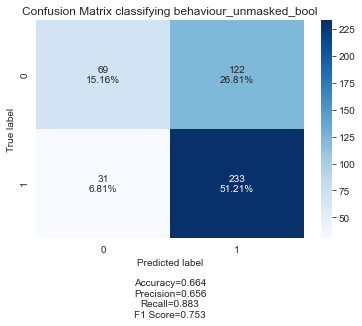

In [34]:
for classif in [clf1, clf2, clf3]:
    print(classif)


    classif = classif.fit(X_train, y_train)
    pred_y = classif.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, pred_y)

    _ = make_confusion_matrix(cf=cf_matrix, 
                      title=f"Confusion Matrix classifying {grouping_var}",
                     sum_stats=True)
    
    _ = plt.show()
    
    classif = None

In [35]:
stop!

SyntaxError: invalid syntax (<ipython-input-35-8c726f94684c>, line 1)

In [ ]:
_ = clf.fit(X = X, 
            y = y)

pred_y = clf.predict(X)
cf_matrix = confusion_matrix(y, pred_y)

_ = make_confusion_matrix(cf=cf_matrix, 
                  title=f"Confusion Matrix classifying {grouping_var}",
                 sum_stats=True)

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X):
    # select rows
    train_X, test_X = X.loc[train_ix, :], X.loc[test_ix, :]
    train_y, test_y = y.loc[train_ix], y.loc[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
    print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    
    _ = clf.fit(X = train_X, 
                y = train_y)
    
    pred_y = clf.predict(test_X)
    cf_matrix = confusion_matrix(test_y, pred_y)
    
    _ = make_confusion_matrix(cf=cf_matrix, 
                      title=f"Confusion Matrix classifying {grouping_var}",
                     sum_stats=True)
    _ = plt.show()

In [ ]:
# accuracies_list = list()
# kfold = KFold(n_splits=100, shuffle=True, random_state=1)
# # enumerate the splits and summarize the distributions
# for train_ix, test_ix in kfold.split(X):
#     # select rows
#     train_X, test_X = X.loc[train_ix, :], X.loc[test_ix, :]
#     train_y, test_y = y.loc[train_ix], y.loc[test_ix]
#     # summarize train and test composition
#     train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
#     test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
# #     print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    
#     _ = clf.fit(X = train_X, 
#                 y = train_y)
    
#     pred_y = clf.predict(test_X)
#     _ = accuracies_list.append(accuracy_score(test_y, pred_y))

In [ ]:
# _ = plt.figure(figsize=(3,5))
# _ = sns.boxplot(y = accuracies_list)
# _ = sns.swarmplot(y = accuracies_list, edgecolor="white", linewidth=1)
# _ = plt.title("Accuracy score Decision Tree\nClassifier kfold cross validation")

In [ ]:
pd.DataFrame(accuracies_list).describe().T

In [ ]:
pd.DataFrame(clf.predict_proba(X))

In [40]:
# train_X = X_train
# train_y = y_train
# test_X = X_test
# test_y = y_test

In [41]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
clf = xgboost.XGBClassifier().fit(train_X.astype(int), train_y)
explainer = shap.Explainer(clf)
shap_values = explainer(train_X.astype(int))

[18:43:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [42]:
pred_y = clf.predict(test_X.astype(int))
accuracy_score(test_y, pred_y)

0.6637362637362637

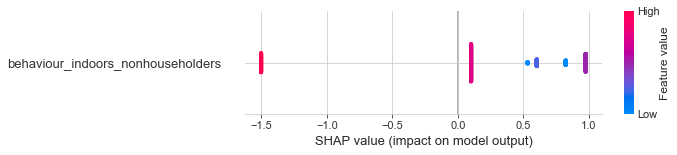

In [43]:
shap.summary_plot(shap_values, train_X.astype(int))

In [ ]:
shap.dependence_plot("norms_people_present_indoors", shap_values.values, train_X.astype(int), interaction_index="auto")

In [ ]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0], max_display=20)

In [ ]:
# for i in range(0, len(shap_values)):
#     fig_tmp = shap.plots.waterfall(shap_values[i], max_display=20, show=False)
#     plt.savefig(f"images/images_for_gif/shap_waterfall_image{i}.png", dpi=100, bbox_inches="tight")
#     plt.close()

# import os

# import imageio
# images = []
# for filename in os.listdir("images/images_for_gif")[0:100]:
#     images.append(imageio.imread("images/images_for_gif/"+filename))
# imageio.mimsave(uri='images/images_for_gif/shap_waterfall_naive_xgboost_non_cat_no_sdt.gif', 
#                 ims=images, 
#                 format="GIF-PIL", 
#                 duration= 2
#                 )

In [ ]:
# visualize all the training set predictions
fc_plot = shap.plots.force(base_value=explainer.expected_value, shap_values=shap_values.values, feature_names=X.columns.tolist())

In [ ]:
# shap.save_html(out_file="images/force_plot_naive_xgboost_non_cat.html", plot=fc_plot, full_html=True)
# shap.save_html(out_file="images/force_plot_naive_xgboost_non_cat_no_sdt.html", plot=fc_plot, full_html=True)

In [ ]:
stop!

In [ ]:
# train an XGBoost model
# model = xgboost.XGBRegressor().fit(X, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [ ]:
explainer.expected_value

In [ ]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0])

In [ ]:
shap_values.values

In [ ]:
# visualize all the training set predictions
shap.plots.force(base_value=explainer.expected_value, shap_values=shap_values.values)

In [ ]:
base_model = HistGradientBoostingClassifier(categorical_features=list(range(X.shape[1])))

In [ ]:
# base_model = DecisionTreeClassifier(random_state = 42)
# base_model = SVC(kernel="rbf", gamma=2, C=1, probability=True)
# base_model = SVC(kernel="linear", gamma=2, C=1, probability=True)
# base_model = RandomForestClassifier(max_depth=max_depth, 
#                              n_estimators=n_estimators, 
#                              max_features=max_features, 
#                              criterion=criterion)

model = BalancedBaggingClassifier(base_estimator=base_model, replacement=True)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize performance
print('Mean accuracy: %.3f' % np.mean(scores))

In [ ]:
pd.DataFrame(scores).describe().T

In [ ]:
_ = plt.figure(figsize=(3,5))
_ = sns.boxplot(y = scores)
_ = sns.swarmplot(y = scores, edgecolor="white", linewidth=1)
_ = plt.title("Accuracy Balanced Bagging\nClassifier with cross validation")

In [ ]:
X = df[feature_selected[0:2]]
clf = HistGradientBoostingClassifier(categorical_features=list(range(X.shape[1])))

In [ ]:
# clf = DecisionTreeClassifier(random_state = 42)
_ = plot_decision_boundary(X=X, y=y, clf=clf, title = 'Decision Boundary - Decision Tree', legend_title = f"{grouping_var}")

In [ ]:
stop!

In [ ]:
shap.initjs()

In [ ]:
import xgboost
import shap

# train an XGBoost model
X_tmp, y_tmp = shap.datasets.boston()
model = xgboost.XGBRegressor().fit(X_tmp, y_tmp)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_tmp)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [ ]:
shap_values[0]

In [ ]:
explainer.expected_value

In [ ]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0])

In [ ]:
shap_values.values

In [ ]:
# visualize all the training set predictions
shap.plots.force(base_value=explainer.expected_value, shap_values=shap_values.values)

In [ ]:
code_df[code_df["Variable name"].isin(feature_selected)]

In [ ]:
code_df[code_df["Type"].isin(feature_selected)]

In [ ]:
# code_df.loc[code_df["Type"].isin(feature_selected), "Variable name"].tolist()

In [ ]:
# grouping_var = "PT_AGE_bool"
if df.shape[0] != original_row_amount: 
    y = df[grouping_var].reset_index(drop=True)
    X = df[feature_selected].reset_index(drop=True)
else:
    y = df[grouping_var]
    X = df[feature_selected]

In [ ]:
# clf = RandomForestClassifier(max_depth=max_depth, 
#                              n_estimators=n_estimators, 
#                              max_features=max_features, 
#                              criterion=criterion)

clf = DecisionTreeClassifier(max_depth=max_depth, 
                             max_features=max_features, 
                             criterion=criterion,
                            random_state=42)

# clf = SVC(kernel="linear", gamma=2, C=1, probability=True)
# example of k-fold cross-validation with an imbalanced dataset
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X):
    # select rows
    train_X, test_X = X.loc[train_ix, :], X.loc[test_ix, :]
    train_y, test_y = y.loc[train_ix], y.loc[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
    print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    
    _ = clf.fit(X = train_X, 
                y = train_y)
    
    pred_y = clf.predict(test_X)
    cf_matrix = confusion_matrix(test_y, pred_y)
    
    _ = make_confusion_matrix(cf=cf_matrix, 
                      title=f"Confusion Matrix classifying {grouping_var}",
                     sum_stats=True)
    _ = plt.show()

In [ ]:
accuracies_list = list()
kfold = KFold(n_splits=100, shuffle=True, random_state=1)
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X):
    # select rows
    train_X, test_X = X.loc[train_ix, :], X.loc[test_ix, :]
    train_y, test_y = y.loc[train_ix], y.loc[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
#     print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    
    _ = clf.fit(X = train_X, 
                y = train_y)
    
    pred_y = clf.predict(test_X)
    _ = accuracies_list.append(accuracy_score(test_y, pred_y))

In [ ]:
_ = plt.figure(figsize=(3,5))
_ = sns.boxplot(y = accuracies_list)
_ = sns.swarmplot(y = accuracies_list, edgecolor="white", linewidth=1)
_ = plt.title("Accuracy score Decision Tree\nClassifier kfold cross validation")

In [ ]:
pd.DataFrame(accuracies_list, columns=["Accuracy"]).describe().T

In [ ]:
np.mean(accuracies_list).round(3), np.std(accuracies_list).round(3)

## Show the Confusion matrix of the full data set out of curiosity

In [ ]:
_ = clf.fit(X = X, 
            y = y)

pred_y = clf.predict(X)
cf_matrix = confusion_matrix(y, pred_y)

_ = make_confusion_matrix(cf=cf_matrix, 
                  title=f"Confusion Matrix classifying {grouping_var}",
                 sum_stats=True)
_ = plt.savefig(f"images/confusion_matrix_{grouping_var}_full_dataset.png", dpi=400, bbox_inches="tight")

In [ ]:
use_test_set_only = False
if use_test_set_only:
    pred_y = clf.predict(test_X)
    target_pred_df = pd.merge(test_y, 
             pd.DataFrame(pred_y, columns=["pred_y"], index=test_y.index), 
             left_index=True, 
             right_index=True
            )
else:
    pred_y = clf.predict(X)
    target_pred_df = pd.merge(y, 
             pd.DataFrame(pred_y, columns=["pred_y"], index=y.index), 
             left_index=True, 
             right_index=True
            )

In [ ]:
tmp = target_pred_df.sum(axis=1)

In [ ]:
group_0_index=tmp[tmp == 0].index.tolist()
group_1_index=tmp[tmp == 2].index.tolist()

In [ ]:
# grouping_var = "PT_AGE_bool"

In [ ]:
tmp_df = df.reset_index(drop=True).loc[group_0_index + group_1_index, feature_selected + [grouping_var]]

In [ ]:
tmp_df.shape

### Distribution plots
Flexible multiplot set of whisker and density plots of all groups

In [ ]:
# Plot
set_plot_limits=False
use_boolean = False
fig, axs = plt.subplots(figsize=(20,20), nrows=len(feature_selected), ncols=2, gridspec_kw={'width_ratios': [1.5, 1]})
fig.subplots_adjust(hspace = 0.25, wspace=0.1)
axs = axs.ravel()
if use_boolean:
    for i in range(0, len(feature_selected)*2, 2):
        _ = sns.histplot(data=tmp_df, x=feature_selected[int(i/2)], hue=f"{grouping_var}_bool", kde=False, bins=10, ax=axs[i])
        _ = sns.boxplot(data=tmp_df, x=f"{grouping_var}_bool", y=feature_selected[int(i/2)], ax=axs[i+1])
else:    
    for i in range(0, len(feature_selected)*2, 2):
        _ = sns.histplot(data=tmp_df, x=feature_selected[int(i/2)], hue=grouping_var, kde=False, bins=10, ax=axs[i])
        _ = sns.boxplot(data=tmp_df, x=grouping_var, y=feature_selected[int(i/2)], ax=axs[i+1])
        
if use_test_set_only:
    _ = plt.savefig("images/density_plots_chosen_users_test_set_only.png", dpi=400, bbox_inches="tight")
else:
    _ = plt.savefig("images/density_plots_chosen_users_full_dataset.png", dpi=400, bbox_inches="tight")

### Plot the learning curve of the latest classifier

In [ ]:
fig = plot_learning_curve(estimator=clf, 
                          title=f"Learning Curve of Decision Tree Classifier of {grouping_var}",
                          X=X, 
                          y=y,
                          groups=None, 
                          cross_color="tab:orange", 
                          test_color="tab:blue", 
                          ylim=None, 
                          cv=None, 
                          n_jobs=None, 
                          train_sizes=np.linspace(.1, 1.0, 10), 
                          figsize=(7,5))
_ = plt.savefig(f"images/learning_curve_decision_tree_{grouping_var}.png", dpi=400, bbox_inches="tight")

In [ ]:
out_file_name = None
# out_file_name = f"images/decision_tree_plot_{grouping_var}"
dot_data = tree.export_graphviz(clf, out_file=out_file_name, 
                      feature_names=feature_selected,  
#                       class_names=df[grouping_var].unique().tolist(),  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

## Check the classification after user selection (it should be basically 100% accurate as we have only chosen users that were classified correctly previously).

In [ ]:
_ = tmp_df.reset_index(drop=True, inplace=True)

In [ ]:
# grouping_var = "PT_AGE_bool"

y = tmp_df[grouping_var]
X = tmp_df[feature_selected]

_ = clf.fit(X = X, 
            y = y)

pred_y = clf.predict(X)
cf_matrix = confusion_matrix(y, pred_y)

_ = make_confusion_matrix(cf=cf_matrix, 
                  title=f"Confusion Matrix classifying {grouping_var}",
                 sum_stats=True)

In [ ]:
accuracies_list = list()
kfold = KFold(n_splits=100, shuffle=True, random_state=1)
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X):
    # select rows
    train_X, test_X = X.loc[train_ix, :], X.loc[test_ix, :]
    train_y, test_y = y.loc[train_ix], y.loc[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
#     print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    
    _ = clf.fit(X = train_X, 
                y = train_y)
    
    pred_y = clf.predict(test_X)
    _ = accuracies_list.append(accuracy_score(test_y, pred_y))

In [ ]:
_ = plt.figure(figsize=(3,5))
_ = sns.boxplot(y = accuracies_list)
_ = sns.swarmplot(y = accuracies_list, edgecolor="white", linewidth=1)
_ = plt.title("Accuracy score Decision Tree\nClassifier kfold cross validation")

In [ ]:
pd.DataFrame(accuracies_list, columns=["Accuracy"]).describe().T

In [ ]:
np.mean(accuracies_list).round(3), np.std(accuracies_list).round(3)

In [ ]:
# !dot -Tpng images/decision_tree_plot_Q5_bool.dot -o images/decision_tree_plot_Q5_bool.png

In [ ]:
feature_selected = feature_importance_df.head(3)["feature"].tolist()
feature_selected

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
_ = ax.scatter(xs=df[feature_selected[0]], 
           ys=df[feature_selected[1]],
           zs=df[feature_selected[2]],
              c=df[grouping_var])

In [ ]:
import plotly.express as px
# test_df = px.data.iris()
# fig = px.scatter_3d(test_df, x='sepal_length', y='sepal_width', z='petal_width',
#               color='species')
# fig.write_html("images/test.html")

In [ ]:
fig = px.scatter_3d(data_frame=df, 
                    x=feature_selected[0], 
                    y=feature_selected[1],
                    z=feature_selected[2],
                    color=grouping_var
                   )
fig.write_html(f'images/{"-".join(feature_selected[0:3])}_interactive_scatterplot.html')

In [ ]:
# grouping_var = "Q8_3"
# y = df[grouping_var]
# X = df[['sdt_needs', 'sdt_motivation']]

# grouping_var = "Q5_bool"
# y = df[grouping_var]
# X = df[feature_selected[0:2]]

# # clf = DecisionTreeClassifier(max_depth=max_depth, 
# #                              max_features=max_features, 
# #                              criterion=criterion)
# clf = SVC(C=1.0, kernel='rbf', probability=True)
# _ = plot_decision_boundary(X=X, y=y, clf=clf, title = 'Decision Boundary - Decision Tree', legend_title = f"{grouping_var}")

In [ ]:
iq_df = pd.read_csv("data/taloustutkimus_james.csv").loc[:, ["ID"]]

In [ ]:
grouped_ids_df = pd.concat([iq_df.loc[group_0_index,:].rename(columns = {"ID": "0_IDs"}), 
iq_df.loc[group_1_index,:].rename(columns = {"ID": "1_IDs"})], axis=1)

In [ ]:
export_grouped_ids = False
if export_grouped_ids:
    _ = grouped_ids_df.to_csv("user_ids_0s_and_1s.csv")

In [ ]:
grouped_ids_df